# EuroSAT Dataset Applying Custom CNN + CBAM Attention Module

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


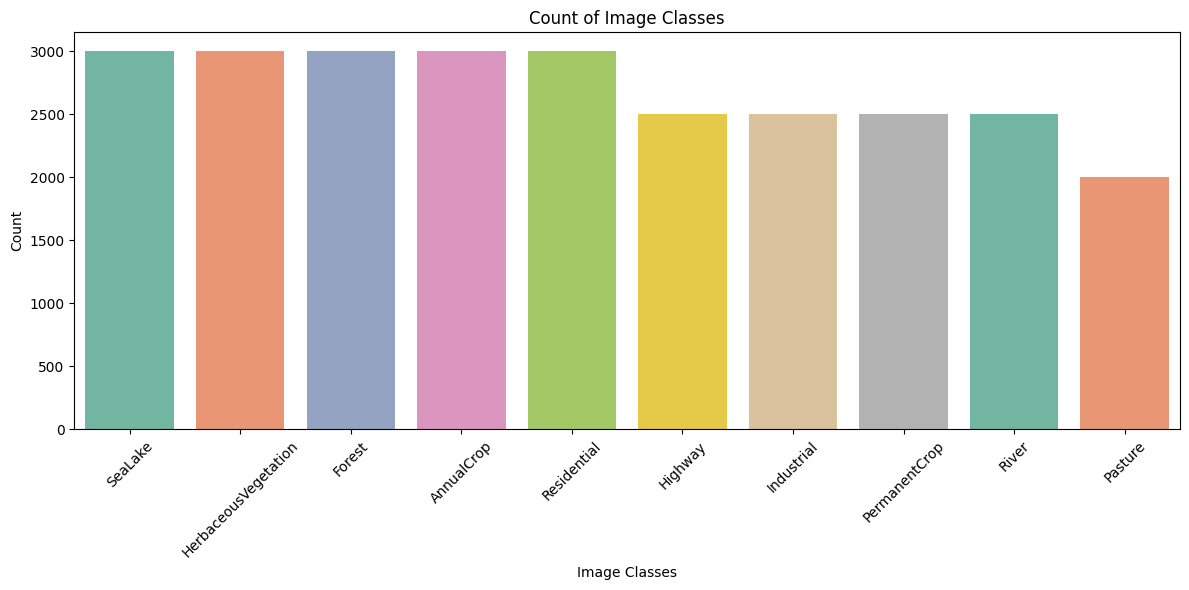

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

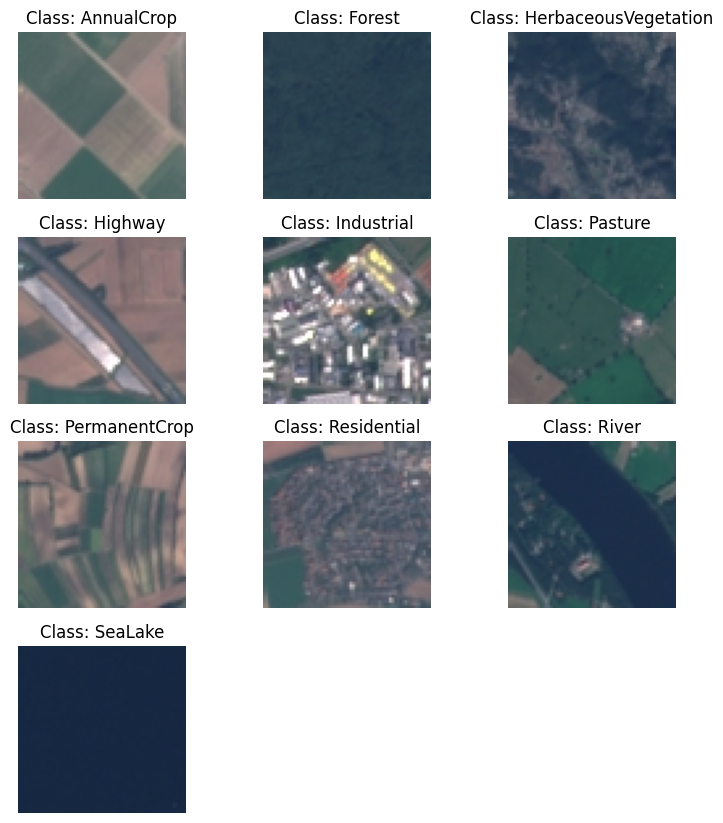

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [26]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # learnable scale factor

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)  # [B, N, C']
        proj_key   = self.key_conv(x).view(B, -1, H * W)                     # [B, C', N]
        energy = torch.bmm(proj_query, proj_key)                            # [B, N, N]
        attention = F.softmax(energy, dim=-1)                               # [B, N, N]

        proj_value = self.value_conv(x).view(B, -1, H * W)                  # [B, C, N]
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))            # [B, C, N]
        out = out.view(B, C, H, W)                                          # reshape

        return self.gamma * out + x  # residual connection

### Convolutional Neural Netwirk (G7CNN) with CBAM Attention Module

In [27]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56
            
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 28 x 28
            SelfAttention(128),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 14 x 14
           

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 512 x 7 x 7
            
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 512 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 512
            nn.Linear(512, 512),                 # → 512
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x).squeeze()    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [40]:
total_class = 10
learning_rate = 0.00001
num_epochs = 30
old_state_dict = torch.load("/kaggle/input/model-v9/pytorch/default/1/model-v9.pt")

model = G7CNN(num_classes=total_class)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in old_state_dict['model_weight'].items() if k in model_dict and v.shape == model_dict[k].shape}

model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.to(device)

print(f"Loaded {len(pretrained_dict)} matching parameters from previous model.")

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# summary(model, input_size=(3, 224, 224))


Loaded 50 matching parameters from previous model.


### Training

In [41]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=30, early_stop_patience=10, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.763, loss=0.839]

Training Loss: 0.839 Acc: 0.763


Validation Loss: 0.306 Acc: 0.893
✅ Best model saved at epoch 1 with validation accuracy: 0.893


Epoch 2/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.893, loss=0.318]

Training Loss: 0.318 Acc: 0.893


Validation Loss: 0.245 Acc: 0.913
✅ Best model saved at epoch 2 with validation accuracy: 0.913


Epoch 3/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.911, loss=0.257]

Training Loss: 0.257 Acc: 0.911


Validation Loss: 0.171 Acc: 0.942
✅ Best model saved at epoch 3 with validation accuracy: 0.942


Epoch 4/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.929, loss=0.209]

Training Loss: 0.209 Acc: 0.929


Validation Loss: 0.153 Acc: 0.950
✅ Best model saved at epoch 4 with validation accuracy: 0.950


Epoch 5/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.938, loss=0.183]

Training Loss: 0.183 Acc: 0.938


Validation Loss: 0.136 Acc: 0.955
✅ Best model saved at epoch 5 with validation accuracy: 0.955


Epoch 6/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.941, loss=0.168]

Training Loss: 0.168 Acc: 0.941


Validation Loss: 0.133 Acc: 0.954


Epoch 7/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.945, loss=0.16] 

Training Loss: 0.160 Acc: 0.945


Validation Loss: 0.139 Acc: 0.952


Epoch 8/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.949, loss=0.149]

Training Loss: 0.149 Acc: 0.949


Validation Loss: 0.140 Acc: 0.957
✅ Best model saved at epoch 8 with validation accuracy: 0.957


Epoch 9/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.954, loss=0.139]

Training Loss: 0.139 Acc: 0.954


Validation Loss: 0.111 Acc: 0.966
✅ Best model saved at epoch 9 with validation accuracy: 0.966


Epoch 10/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.955, loss=0.133]

Training Loss: 0.133 Acc: 0.955


Validation Loss: 0.121 Acc: 0.959


Epoch 11/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.958, loss=0.126]

Training Loss: 0.126 Acc: 0.958


Validation Loss: 0.149 Acc: 0.952


Epoch 12/30: 100%|██████████| 296/296 [01:11<00:00,  4.16it/s, acc=0.96, loss=0.121] 

Training Loss: 0.121 Acc: 0.960


Validation Loss: 0.116 Acc: 0.963


Epoch 13/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.96, loss=0.115] 

Training Loss: 0.115 Acc: 0.960


Validation Loss: 0.124 Acc: 0.959


Epoch 14/30: 100%|██████████| 296/296 [01:11<00:00,  4.17it/s, acc=0.962, loss=0.112]

Training Loss: 0.112 Acc: 0.962


Validation Loss: 0.118 Acc: 0.964


Epoch 15/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.962, loss=0.108]

Training Loss: 0.108 Acc: 0.962


Validation Loss: 0.100 Acc: 0.971
✅ Best model saved at epoch 15 with validation accuracy: 0.971


Epoch 16/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.964, loss=0.102]

Training Loss: 0.102 Acc: 0.964


Validation Loss: 0.093 Acc: 0.970


Epoch 17/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.966, loss=0.0994]

Training Loss: 0.099 Acc: 0.966


Validation Loss: 0.124 Acc: 0.961


Epoch 18/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.964, loss=0.103]

Training Loss: 0.103 Acc: 0.964


Validation Loss: 0.117 Acc: 0.960


Epoch 19/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.967, loss=0.0942]

Training Loss: 0.094 Acc: 0.967


Validation Loss: 0.101 Acc: 0.965


Epoch 20/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.969, loss=0.0936]

Training Loss: 0.094 Acc: 0.969


Validation Loss: 0.092 Acc: 0.974
✅ Best model saved at epoch 20 with validation accuracy: 0.974


Epoch 21/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.968, loss=0.0907]

Training Loss: 0.091 Acc: 0.968


Validation Loss: 0.099 Acc: 0.970


Epoch 22/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.969, loss=0.0884]

Training Loss: 0.088 Acc: 0.969


Validation Loss: 0.086 Acc: 0.971


Epoch 23/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.971, loss=0.0846]

Training Loss: 0.085 Acc: 0.971


Validation Loss: 0.124 Acc: 0.959


Epoch 24/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.972, loss=0.0812]

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.103 Acc: 0.970


Epoch 25/30: 100%|██████████| 296/296 [01:10<00:00,  4.19it/s, acc=0.971, loss=0.0817]

Training Loss: 0.082 Acc: 0.971


Validation Loss: 0.112 Acc: 0.960


Epoch 26/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.971, loss=0.0829]

Training Loss: 0.083 Acc: 0.971


Validation Loss: 0.094 Acc: 0.970


Epoch 27/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.974, loss=0.0772]

Training Loss: 0.077 Acc: 0.974


Validation Loss: 0.077 Acc: 0.977
✅ Best model saved at epoch 27 with validation accuracy: 0.977


Epoch 28/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.974, loss=0.0763]

Training Loss: 0.076 Acc: 0.974


Validation Loss: 0.088 Acc: 0.974


Epoch 29/30: 100%|██████████| 296/296 [01:10<00:00,  4.18it/s, acc=0.975, loss=0.0729]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.082 Acc: 0.972


Epoch 30/30: 100%|██████████| 296/296 [01:10<00:00,  4.17it/s, acc=0.975, loss=0.0686]

Training Loss: 0.069 Acc: 0.975


Validation Loss: 0.087 Acc: 0.973
Training Time: 2336.71 seconds ---> 38.95 minutes


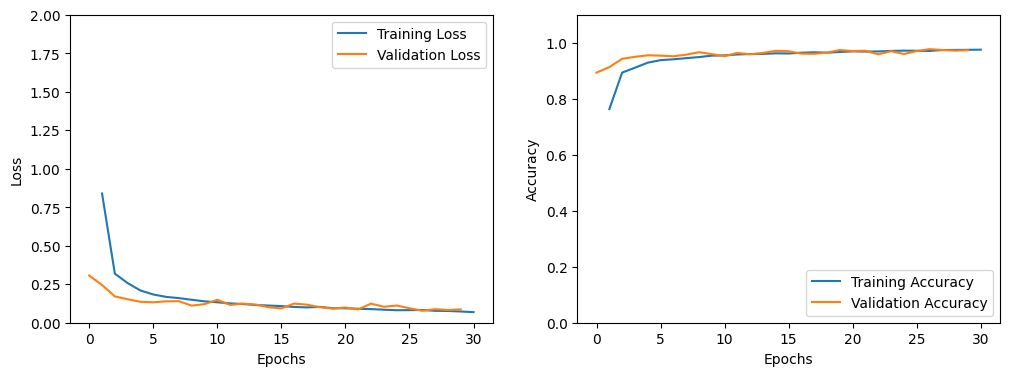

In [42]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [43]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 27) - Validation Loss: 0.074, Validation Accuracy: 0.977


In [44]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.975
Test Time: 6.91 seconds ---> 0.12 minutes


In [45]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       450
           1       0.99      0.99      0.99       450
           2       0.97      0.95      0.96       450
           3       0.98      0.98      0.98       375
           4       0.99      0.98      0.99       375
           5       0.96      0.95      0.96       300
           6       0.93      0.97      0.95       375
           7       1.00      0.99      0.99       450
           8       0.96      0.98      0.97       375
           9       0.99      0.98      0.99       450

    accuracy                           0.98      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.98      0.98      0.98      4050

Class 0 Accuracy: 0.967
Class 1 Accuracy: 0.984
Class 2 Accuracy: 0.956
Class 3 Accuracy: 0.963
Class 4 Accuracy: 0.987
Class 5 Accuracy: 0.960
Class 6 Accuracy: 0.971
Class 7 Accuracy: 0.993
Class 8 Accuracy: 0.973
Cl

### Confusion Matrix

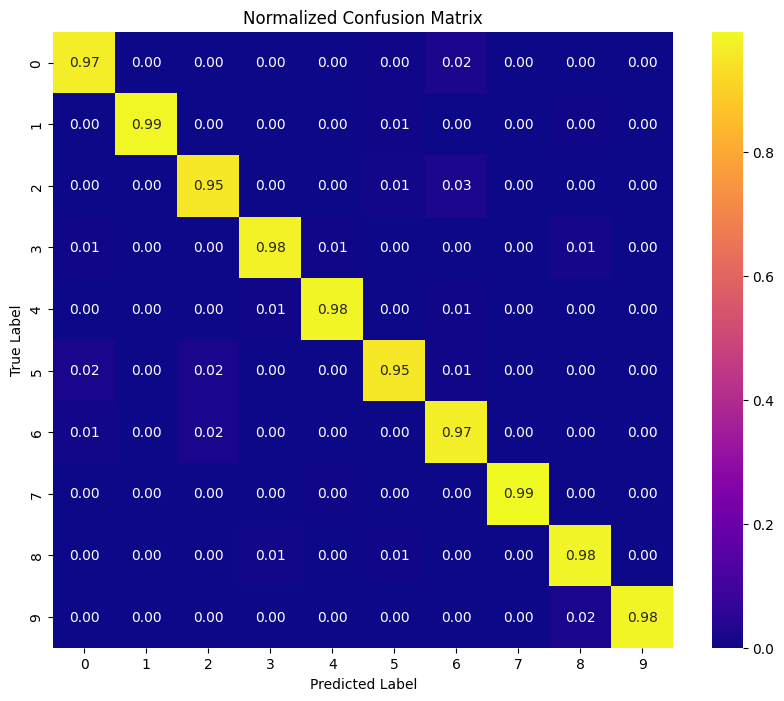

In [46]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

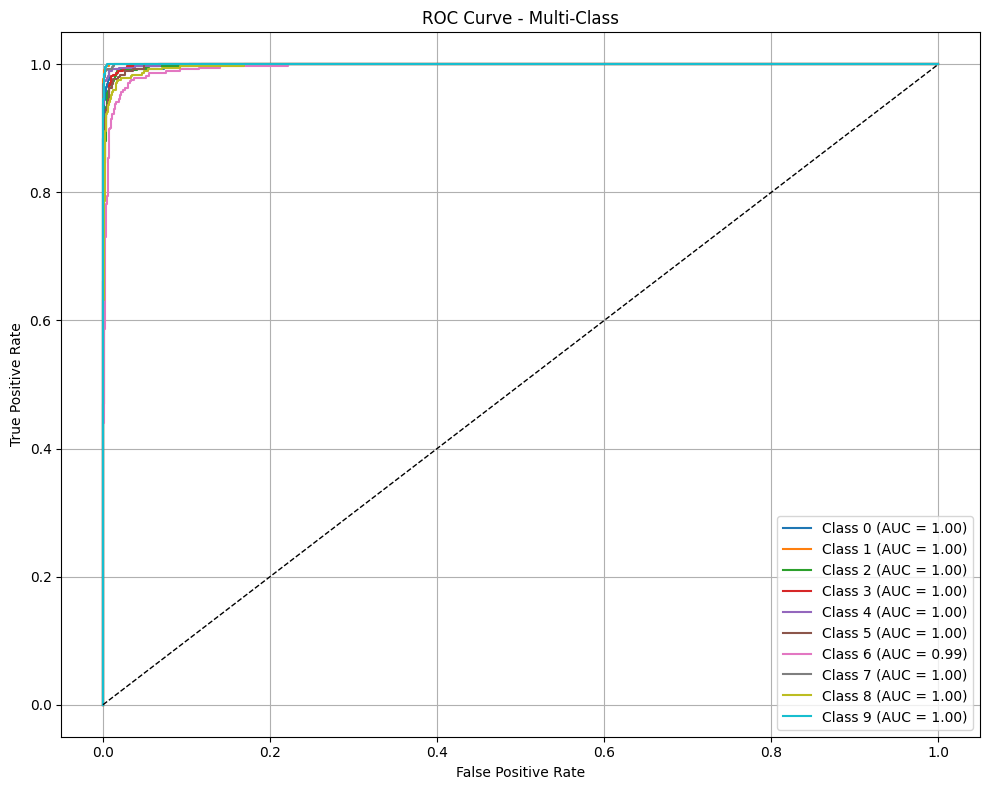

In [47]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()